## Odszumianie EKG - metody oparte na uczeniu głębokim
Ta część została napisana w notatnikach interaktywnych. Dodatkowo załączony został plik .py, wygenerowany na bazie tego notatnika

In [ ]:
!pip uninstall tensorflow tensorflow-gpu seaborn --yes
!pip install h5py==2.10.0 tensorflow-gpu==1.14.0 keras==2.2.5 numpy==1.19.2 seaborn==0.10.1 scipy==1.5.2 scikit-learn==0.23.2 prettytable==1.0.1 wfdb==3.1.1

In [1]:
# Download data from PhysioNet
! rm -r *
!ls
!wget https://physionet.org/static/published-projects/qtdb/qt-database-1.0.0.zip 
!wget https://physionet.org/static/published-projects/nstdb/mit-bih-noise-stress-test-database-1.0.0.zip
!ls
print('Downloading data: Done')

!mkdir data
!unzip qt-database-1.0.0.zip >> /dev/null
!unzip mit-bih-noise-stress-test-database-1.0.0.zip >> /dev/null
!mv qt-database-1.0.0 data/
!mv mit-bih-noise-stress-test-database-1.0.0 data/
!rm qt-database-1.0.0.zip
!rm mit-bih-noise-stress-test-database-1.0.0.zip
!ls
!ls data
print('Extracting data: Done')

--2022-06-12 18:43:06--  https://physionet.org/static/published-projects/qtdb/qt-database-1.0.0.zip
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87119682 (83M) [application/zip]
Saving to: ‘qt-database-1.0.0.zip’

qt-database-1.0.0.z 100%[===================>]  83.08M  35.4MB/s    in 2.3s    

2022-06-12 18:43:10 (35.4 MB/s) - ‘qt-database-1.0.0.zip’ saved [87119682/87119682]

--2022-06-12 18:43:10--  https://physionet.org/static/published-projects/nstdb/mit-bih-noise-stress-test-database-1.0.0.zip
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70945297 (68M) [application/zip]
Saving to: ‘mit-bih-noise-stress-test-database-1.0.0.zip’

mit-bih-noise-stres 100%[===================>]  67.66M  24.7MB/s    in 2.7s    

In [2]:
# Imports

import glob
import numpy as np
from scipy.signal import resample_poly
import wfdb
import math
import _pickle as pickle
import matplotlib.pyplot as plt

## Przygotowanie danych


### Sygnał EKG

In [1]:
QTpath='data/qt-database-1.0.0/'
# Desired sampling frecuency
newFs = 360

# Preprocessing signals
namesPath = glob.glob(QTpath + "/*.dat")

# final list that will contain all signals and beats processed
QTDatabaseSignals = dict()

register_name = None
for i in namesPath:

    # reading signals
    aux = i.split('.dat')
    register_name = aux[0].split('/')[-1]
    signal, fields = wfdb.rdsamp(aux[0])
    qu = len(signal)

    # reading annotations
    ann = wfdb.rdann(aux[0], 'pu1')
    anntype = ann.symbol
    annSamples = ann.sample

    # Obtaining P wave start positions
    Anntype = np.array(anntype)
    idx = Anntype == 'p'
    Pidx = annSamples[idx]
    idxS = Anntype == '('
    Sidx = annSamples[idxS]
    idxR = Anntype == 'N'
    Ridx = annSamples[idxR]

    ind = np.zeros(len(Pidx))

    for j in range(len(Pidx)):
        arr = np.where(Pidx[j] > Sidx)
        arr = arr[0]
        ind[j] = arr[-1]

    ind = ind.astype(np.int64)
    Pstart = Sidx[ind]

    # Shift 40ms before P wave start
    Pstart = Pstart - int(0.04*fields['fs'])

    # Extract first channel
    auxSig = signal[0:qu, 0]

    # Beats separation and removing outliers
    # Beats separation and removal of the vectors that contain more or equal than
    # two beats based on QRS annotations
    beats = list()
    for k in range(len(Pstart)-1):
        remove = (Ridx > Pstart[k]) & (Ridx < Pstart[k+1])
        if np.sum(remove) < 2:
            beats.append(auxSig[Pstart[k]:Pstart[k+1]])

    # Creating the list that will contain each beat per signal
    beatsRe = list()

    # processing each beat
    for k in range(len(beats)):
        # Padding data to avoid edge effects caused by resample
        L = math.ceil(len(beats[k])*newFs/fields['fs'])
        normBeat = list(reversed(beats[k])) + list(beats[k]) + list(reversed(beats[k]))

        # resample beat by beat and saving it
        res = resample_poly(normBeat, newFs, fields['fs'])
        res = res[L-1:2*L-1]
        beatsRe.append(res)

    # storing all beats in each corresponding signal, list of list
    QTDatabaseSignals[register_name] = beatsRe

# Save Data
with open('data/QTDatabase.pkl', 'wb') as output:  # Overwrites any existing file.
    pickle.dump(QTDatabaseSignals, output)
print('=========================================================')
print('MIT QT database saved as pickle file')

MIT QT database saved as pickle file


### Szum

In [2]:
NSTDBPath = 'data/mit-bih-noise-stress-test-database-1.0.0/bw'
signals, fields = wfdb.rdsamp(NSTDBPath)

for key in fields:
    print(key, fields[key])

np.save('data/NoiseBWL', signals)

with open('data/NoiseBWL.pkl', 'wb') as output:
    pickle.dump(signals, output)
print('=========================================================')
print('MIT BIH data noise stress test database (NSTDB) saved as pickle')

fs 360
sig_len 650000
n_sig 2
base_date None
base_time None
units ['mV', 'mV']
sig_name ['noise1', 'noise2']
comments []
MIT BIH data noise stress test database (NSTDB) saved as pickle


In [3]:
NSTDBPath = 'data/mit-bih-noise-stress-test-database-1.0.0/ma'
signals, fields = wfdb.rdsamp(NSTDBPath)

for key in fields:
    print(key, fields[key])

np.save('data/NoiseMA', signals)
# Save Data
with open('data/NoiseMA.pkl', 'wb') as output:
    pickle.dump(signals, output)
print('=========================================================')
print('MIT BIH data noise stress test database (NSTDB) saved as pickle')

fs 360
sig_len 650000
n_sig 2
base_date None
base_time None
units ['mV', 'mV']
sig_name ['noise1', 'noise2']
comments []
MIT BIH data noise stress test database (NSTDB) saved as pickle


In [4]:
NSTDBPath = 'data/mit-bih-noise-stress-test-database-1.0.0/em'
signals, fields = wfdb.rdsamp(NSTDBPath)

for key in fields:
    print(key, fields[key])

np.save('data/NoiseEM', signals)
# Save Data
with open('data/NoiseEM.pkl', 'wb') as output:
    pickle.dump(signals, output)
print('=========================================================')
print('MIT BIH data noise stress test database (NSTDB) saved as pickle')

fs 360
sig_len 650000
n_sig 2
base_date None
base_time None
units ['mV', 'mV']
sig_name ['noise1', 'noise2']
comments []
MIT BIH data noise stress test database (NSTDB) saved as pickle


### Łączenie danych

In [5]:
print('Getting the Data ready ... ')

# The seed is used to ensure the ECG always have the same contamination level
# this enhance reproducibility
seed = 1234
np.random.seed(seed=seed)

# Load QT Database
with open('data/QTDatabase.pkl', 'rb') as input:
    # dict {register_name: beats_list}
    qtdb = pickle.load(input)

# Load NSTDB BWT
with open('data/NoiseBWL.pkl', 'rb') as input:
    nstdbwl = pickle.load(input)

# Load NSTDB MA
with open('data/NoiseMA.pkl', 'rb') as input:
    nstdma = pickle.load(input)

# Load NSTDB EN
with open('data/NoiseEM.pkl', 'rb') as input:
    nstdem = pickle.load(input)


# NSTDB

noise_channel1 = nstdbwl[:, 0]
noise_channel2 = nstdbwl[:, 1]

noise_channel3 = nstdma[:, 0]
noise_channel4 = nstdma[:, 1]

noise_channel5 = nstdem[:, 0]
noise_channel6 = nstdem[:, 1]


# Data split

noise_test_bwt = np.concatenate(
    (noise_channel1[0:int(noise_channel1.shape[0] * 0.13)], noise_channel2[0:int(noise_channel2.shape[0] * 0.13)]))
noise_train_bwt = np.concatenate((noise_channel1[int(noise_channel1.shape[0] * 0.13):-1],
                              noise_channel2[int(noise_channel2.shape[0] * 0.13):-1]))

noise_test_ma = np.concatenate(
    (noise_channel3[0:int(noise_channel3.shape[0] * 0.13)], noise_channel4[0:int(noise_channel4.shape[0] * 0.13)]))
noise_train_ma = np.concatenate((noise_channel3[int(noise_channel3.shape[0] * 0.13):-1],
                              noise_channel4[int(noise_channel4.shape[0] * 0.13):-1]))

noise_test_em = np.concatenate(
    (noise_channel5[0:int(noise_channel5.shape[0] * 0.13)], noise_channel6[0:int(noise_channel6.shape[0] * 0.13)]))
noise_train_em = np.concatenate((noise_channel5[int(noise_channel5.shape[0] * 0.13):-1],
                              noise_channel6[int(noise_channel6.shape[0] * 0.13):-1]))


# QTDatabase

beats_train = []
beats_test = []

test_set = ['sel123',  # Record from MIT-BIH Arrhythmia Database
            'sel233',  # Record from MIT-BIH Arrhythmia Database

            'sel302',  # Record from MIT-BIH ST Change Database
            'sel307',  # Record from MIT-BIH ST Change Database

            'sel820',  # Record from MIT-BIH Supraventricular Arrhythmia Database
            'sel853',  # Record from MIT-BIH Supraventricular Arrhythmia Database

            'sel16420',  # Record from MIT-BIH Normal Sinus Rhythm Database
            'sel16795',  # Record from MIT-BIH Normal Sinus Rhythm Database

            'sele0106',  # Record from European ST-T Database
            'sele0121',  # Record from European ST-T Database

            'sel32',  # Record from ``sudden death'' patients from BIH
            'sel49',  # Record from ``sudden death'' patients from BIH

            'sel14046',  # Record from MIT-BIH Long-Term ECG Database
            'sel15814',  # Record from MIT-BIH Long-Term ECG Database
            ]

# Creating the train and test dataset, each datapoint has 512 samples and is zero padded
# beats bigger that 512 samples are discarded to avoid wrong split beats ans to reduce
# computation.
skip_beats = 0
samples = 512
qtdb_keys = list(qtdb.keys())

for i in range(len(qtdb_keys)):
    signal_name = qtdb_keys[i]

    for b in qtdb[signal_name]:

        b_np = np.zeros(samples)
        b_sq = np.array(b)

        # There are beats with more than 512 samples (could be up to 3500 samples)
        # Creating a threshold of 512 - init_padding samples max. gives a good compromise between
        # the samples amount and the discarded signals amount
        # before:
        # train: 74448  test: 13362
        # after:
        # train: 71893 test: 13306  (discarded train: ~4k datapoints test: ~50)

        init_padding = 16
        if b_sq.shape[0] > (samples - init_padding):
            skip_beats += 1
            continue

        b_np[init_padding:b_sq.shape[0] + init_padding] = b_sq - (b_sq[0] + b_sq[-1]) / 2

        if signal_name in test_set:
            beats_test.append(b_np)
        else:
            beats_train.append(b_np)

# Noise was added in a proportion from 0.2 to 2 times the ECG signal amplitude
# Similar to
# W. Muldrow, R.G. Mark, & Moody, G. B. (1984).
# A noise stress test for arrhythmia detectors.
# Computers in Cardiology, 381–384

sn_train = []
sn_test = []

noise_index = 0

# Adding noise to train
rnd_train = np.random.randint(low=20, high=200, size=len(beats_train)) / 100
for i in range(len(beats_train)):
    beat_max_value = np.max(beats_train[i]) - np.min(beats_train[i])

    noise_bwt = noise_train_bwt[noise_index:noise_index + samples]
    noise_max_value_bwt = np.max(noise_bwt) - np.min(noise_bwt)
    Ase_bwt = noise_max_value_bwt / beat_max_value
    alpha = rnd_train[i] / Ase_bwt

    noise_ma = noise_train_ma[noise_index:noise_index + samples]
    noise_max_value_ma = np.max(noise_ma) - np.min(noise_ma)
    Ase_ma = noise_max_value_ma / beat_max_value
    beta = rnd_train[i] / Ase_ma

    noise_em = noise_train_bwt[noise_index:noise_index + samples]
    noise_max_value_em = np.max(noise_em) - np.min(noise_em)
    Ase_em = noise_max_value_em / beat_max_value
    gamma = rnd_train[i] / Ase_em

    signal_noise = beats_train[i] + alpha/3 * noise_bwt + beta/3 * noise_ma + gamma/3 * noise_em

    sn_train.append(signal_noise)
    noise_index += samples

    if noise_index > (len(noise_train_bwt) - samples):
        noise_index = 0

# Adding noise to test
noise_index = 0
rnd_test = np.random.randint(low=20, high=200, size=len(beats_test)) / 100
for i in range(len(beats_test)):
    beat_max_value = np.max(beats_test[i]) - np.min(beats_test[i])

    noise_bwt = noise_test_bwt[noise_index:noise_index + samples]
    noise_max_value_bwt = np.max(noise_bwt) - np.min(noise_bwt)
    Ase_bwt = noise_max_value_bwt / beat_max_value
    alpha = rnd_test[i] / Ase_bwt

    noise_ma = noise_test_ma[noise_index:noise_index + samples]
    noise_max_value_ma = np.max(noise_ma) - np.min(noise_ma)
    Ase_ma = noise_max_value_ma / beat_max_value
    beta = rnd_test[i] / Ase_ma

    noise_em = noise_test_bwt[noise_index:noise_index + samples]
    noise_max_value_em = np.max(noise_em) - np.min(noise_em)
    Ase_em = noise_max_value_em / beat_max_value
    gamma = rnd_test[i] / Ase_em

    signal_noise = beats_test[i] + alpha/3 * noise_bwt + beta/3 * noise_ma + gamma/3 * noise_em

    sn_test.append(signal_noise)
    noise_index += samples

    if noise_index > (len(noise_test_bwt) - samples):
        noise_index = 0

X_train = np.array(sn_train)
y_train = np.array(beats_train)

X_test = np.array(sn_test)
y_test = np.array(beats_test)

X_train = np.expand_dims(X_train, axis=2)
y_train = np.expand_dims(y_train, axis=2)

X_test = np.expand_dims(X_test, axis=2)
y_test = np.expand_dims(y_test, axis=2)

Dataset = [X_train, y_train, X_test, y_test]

print('Dataset ready to use.')

Getting the Data ready ... 
Dataset ready to use.


In [ ]:
print("DATASET SHAPE")
print(f'Training {X_train.shape}')
print(f'Training {X_test.shape}')

DATASET SHAPE
Training (72002, 512, 1)
Training (13316, 512, 1)


## Modele

In [ ]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv1D, Flatten, Dropout, BatchNormalization, concatenate, Activation, Input, Conv2DTranspose, Lambda, LSTM, Reshape, Embedding

import keras.backend as K

def Conv1DTranspose(input_tensor, filters, kernel_size, strides=2, activation='relu', padding='same'):
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(input_tensor)
    x = Conv2DTranspose(filters=filters,
                        kernel_size=(kernel_size, 1),
                        activation=activation,
                        strides=(strides, 1),
                        padding=padding)(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    return x


def FCN_DAE():
    # Implementation of FCN_DAE approach presented in
    # Chiang, H. T., Hsieh, Y. Y., Fu, S. W., Hung, K. H., Tsao, Y., & Chien, S. Y. (2019).
    # Noise reduction in ECG signals using fully convolutional denoising autoencoders.
    # IEEE Access, 7, 60806-60813.

    input_shape = (512, 1)
    input = Input(shape=input_shape)

    # Encoder
    x = Conv1D(filters=40,
               input_shape=(512, 1),
               kernel_size=16,
               activation='elu',
               strides=2,
               padding='same')(input)

    x = BatchNormalization()(x)

    x = Conv1D(filters=20,
               kernel_size=16,
               activation='elu',
               strides=2,
               padding='same')(x)

    x = BatchNormalization()(x)

    x = Conv1D(filters=20,
               kernel_size=16,
               activation='elu',
               strides=2,
               padding='same')(x)

    x = BatchNormalization()(x)

    x = Conv1D(filters=20,
               kernel_size=16,
               activation='elu',
               strides=2,
               padding='same')(x)

    x = BatchNormalization()(x)

    x = Conv1D(filters=40,
               kernel_size=16,
               activation='elu',
               strides=2,
               padding='same')(x)

    x = BatchNormalization()(x)

    x = Conv1D(filters=1,
               kernel_size=16,
               activation='elu',
               strides=1,
               padding='same')(x)

    x = BatchNormalization()(x)

    # Decoder
    x = Conv1DTranspose(input_tensor=x,
                        filters=1,
                        kernel_size=16,
                        activation='elu',
                        strides=1,
                        padding='same')

    x = BatchNormalization()(x)

    x = Conv1DTranspose(input_tensor=x,
                        filters=40,
                        kernel_size=16,
                        activation='elu',
                        strides=2,
                        padding='same')

    x = BatchNormalization()(x)

    x = Conv1DTranspose(input_tensor=x,
                        filters=20,
                        kernel_size=16,
                        activation='elu',
                        strides=2,
                        padding='same')

    x = BatchNormalization()(x)

    x = Conv1DTranspose(input_tensor=x,
                        filters=20,
                        kernel_size=16,
                        activation='elu',
                        strides=2,
                        padding='same')

    x = BatchNormalization()(x)

    x = Conv1DTranspose(input_tensor=x,
                        filters=20,
                        kernel_size=16,
                        activation='elu',
                        strides=2,
                        padding='same')

    x = BatchNormalization()(x)

    x = Conv1DTranspose(input_tensor=x,
                        filters=40,
                        kernel_size=16,
                        activation='elu',
                        strides=2,
                        padding='same')

    x = BatchNormalization()(x)

    predictions = Conv1DTranspose(input_tensor=x,
                        filters=1,
                        kernel_size=16,
                        activation='linear',
                        strides=1,
                        padding='same')

    model = Model(inputs=[input], outputs=predictions)
    return model


def DRRN_denoising():
    # Implementation of DRNN approach presented in
    # Antczak, K. (2018). Deep recurrent neural networks for ECG signal denoising.
    # arXiv preprint arXiv:1807.11551.    

    model = Sequential()
    model.add(LSTM(64, input_shape=(512, 1), return_sequences=True))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='linear'))

    return model

## Funkcje wykorztystywane podczas treningu

In [4]:
import keras
from keras import backend as K
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from keras import losses
from sklearn.model_selection import train_test_split

def ssd_loss(y_true, y_pred):
    return K.sum(K.square(y_pred - y_true), axis=-2)

def train_dl(Dataset, experiment):

    print('Deep Learning pipeline: Training the model for exp ' + str(experiment))

    [X_train, y_train, X_test, y_test] = Dataset

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, shuffle=True, random_state=1)

    if experiment == 'FCN-DAE':
        # FCN_DAE
        model = FCN_DAE()
        model_label = 'FCN_DAE'
        criterion = ssd_loss

    if experiment == 'DRNN':
        # DRNN
        model = DRRN_denoising()
        model_label = 'DRNN'
        criterion = keras.losses.mean_squared_error

    print('\n ' + model_label + '\n ')

    model.summary()

    epochs = 100
    batch_size = 128
    lr = 1e-3
    minimum_lr = 1e-10


    model.compile(loss=criterion,
                  optimizer=keras.optimizers.Adam(lr=lr),
                  metrics=[losses.mean_squared_error, ssd_loss])

    # checkpoint
    model_filepath = model_label + '_weights.best.hdf5'

    checkpoint = ModelCheckpoint(model_filepath,
                                 monitor="val_loss",
                                 verbose=1,
                                 save_best_only=True,
                                 mode='min', 
                                 save_weights_only=True)
    
    reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                                  factor=0.5,
                                  min_delta=0.05,
                                  mode='min',
                                  patience=2,
                                  min_lr=minimum_lr,
                                  verbose=1)
    
    early_stop = EarlyStopping(monitor="val_loss", 
                               min_delta=0.05,
                               mode='min', 
                               patience=10,
                               verbose=1)
    
    model.fit(x=X_train, y=y_train,
              validation_data=(X_val, y_val),
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              callbacks=[checkpoint, reduce_lr, early_stop])

    K.clear_session()



def test_dl(Dataset, experiment):

    print('Deep Learning pipeline: Testing the model')

    [train_set, train_set_GT, X_test, y_test] = Dataset

    batch_size = 32

    if experiment == 'FCN-DAE':
        # FCN_DAE
        model = FCN_DAE()
        model_label = 'FCN_DAE'
        criterion = ssd_loss

    if experiment == 'DRNN':
        # DRNN
        model = DRRN_denoising()
        model_label = 'DRNN'
        criterion = keras.losses.mean_squared_error

    print('\n ' + model_label + '\n ')

    model.summary()

    model.compile(loss=criterion,
                  optimizer=keras.optimizers.Adam(lr=0.01),
                  metrics=[keras.losses.mean_squared_error, ssd_loss])

    # checkpoint
    model_filepath = model_label + '_weights.best.hdf5'
    # load weights
    model.load_weights(model_filepath)

    # Test score
    y_pred = model.predict(X_test, batch_size=batch_size, verbose=1)


    K.clear_session()

    return [X_test, y_test, y_pred]
    

## TRENING

In [8]:
dl_experiments = ['DRNN',
                  'FCN-DAE'
                  ]

In [ ]:
for experiment in range(len(dl_experiments)):
    train_dl(Dataset, dl_experiments[experiment])

    [X_test, y_test, y_pred] = test_dl(Dataset, dl_experiments[experiment])

    test_results = [X_test, y_test, y_pred]

    # Save Results
    with open('test_results_' + dl_experiments[experiment] + '.pkl', 'wb') as output: 
        pickle.dump(test_results, output)

    print('Results from experiment ' + dl_experiments[experiment] + ' saved')

Deep Learning pipeline: Training the model for exp DRNN



(50401, 512, 1)
(21601, 512, 1)
(50401, 512, 1)
(21601, 512, 1)

 DRNN
 
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 512, 64)           16896     
_________________________________________________________________
dense_1 (Dense)              (None, 512, 64)           4160      
_________________________________________________________________
dense_2 (Dense)              (None, 512, 64)           4160      
_________________________________________________________________
dense_3 (Dense)              (None, 512, 1)            65        
Total params: 25,281
Trainable params: 25,281
Non-trainable params: 0
_________________________________________________________________

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50401 samp

## Metryki

In [5]:
from sklearn.metrics import mean_squared_error

def SSD(y, y_pred):
    return np.sum(np.square(y - y_pred), axis=1)

def MAD(y, y_pred):
    return np.max(np.abs(y - y_pred), axis=1)

def RMSE(y, y_pred):
  return np.sqrt(np.mean(np.sum(np.square(y - y_pred), axis=1), axis = 1))


In [6]:
from prettytable import PrettyTable

def generate_table(metrics, metric_values, Exp_names):
    # Print tabular results in the console, in a pretty way
    print('\n')

    tb = PrettyTable()
    ind = 0

    for exp_name in Exp_names:

        tb.field_names = ['Method/Model'] + metrics

        tb_row = []
        tb_row.append(exp_name)

        for metric in metric_values:
            m_mean = np.mean(metric[ind])
            m_std = np.std(metric[ind])
            tb_row.append('{:.3f}'.format(m_mean) + ' (' + '{:.3f}'.format(m_std) + ')')

        tb.add_row(tb_row)
        ind += 1

    print(tb)

In [9]:
# Load Results DRNN
with open('test_results_' + dl_experiments[0] + '.pkl', 'rb') as input:
    test_DRNN = pickle.load(input)

# Load Results FCN_DAE
with open('test_results_' + dl_experiments[1] + '.pkl', 'rb') as input:
    test_FCN_DAE = pickle.load(input)



####### Calculate Metrics #######

print('Calculating metrics ...')

# DL Metrics

# Exp FCN-DAE

[X_test, y_test, y_pred] = test_DRNN

SSD_values_DL_DRNN = SSD(y_test, y_pred)

MAD_values_DL_DRNN = MAD(y_test, y_pred)

RMSE_values_DL_DRNN = RMSE(y_test, y_pred)

# Exp FCN-DAE

[X_test, y_test, y_pred] = test_FCN_DAE

SSD_values_DL_FCN_DAE = SSD(y_test, y_pred)

MAD_values_DL_FCN_DAE = MAD(y_test, y_pred)

RMSE_values_DL_FCN_DAE = RMSE(y_test, y_pred)

SSD_all = [SSD_values_DL_DRNN,
           SSD_values_DL_FCN_DAE,
           
           ]

MAD_all = [
           MAD_values_DL_DRNN,
           MAD_values_DL_FCN_DAE,
           
           ]

RMSE_all = [
            RMSE_values_DL_DRNN,
            RMSE_values_DL_FCN_DAE,
            ]

metrics = ['SSD', 'MAD', 'RMSE']
metric_values = [SSD_all, MAD_all, RMSE_all]

# Metrics table
generate_table(metrics, metric_values, dl_experiments)


Calculating metrics ...


+--------------+-----------------+---------------+---------------+
| Method/Model |       SSD       |      MAD      |      RMSE     |
+--------------+-----------------+---------------+---------------+
|     DRNN     | 11.486 (12.630) | 0.689 (0.384) | 3.047 (1.483) |
|   FCN-DAE    |  4.736 (7.252)  | 0.429 (0.288) | 1.859 (1.131) |
+--------------+-----------------+---------------+---------------+


## Wykresy

In [10]:
[X_test_1, y_test_1, y_pred_1] = test_DRNN
[X_test_2, y_test_2, y_pred_2] = test_FCN_DAE

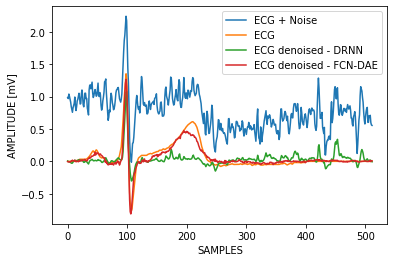

In [11]:
plt.plot(X_test_1[3390], label="ECG + Noise")
plt.plot(y_test_1[3390], label="ECG")
plt.plot(y_pred_1[3390], label="ECG denoised - DRNN")
plt.plot(y_pred_2[3390], label="ECG denoised - FCN-DAE")
plt.xlabel("SAMPLES")
plt.ylabel("AMPLITUDE [mV]")
plt.legend()
plt.show()

357


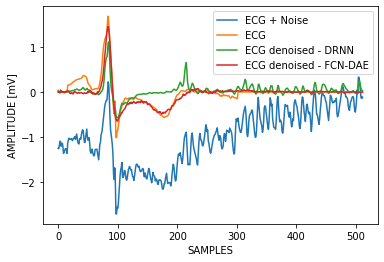

5923


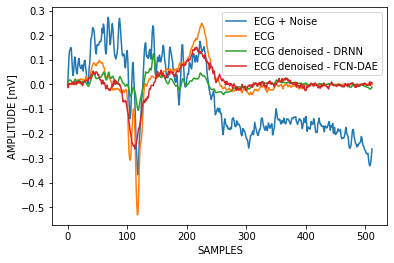

4208


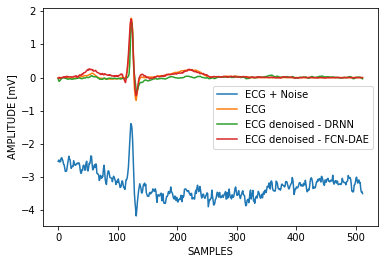

5322


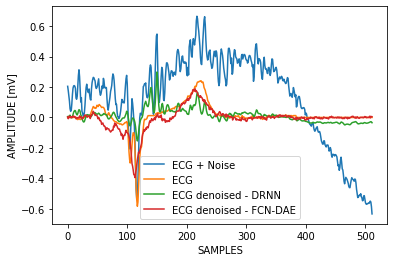

2222


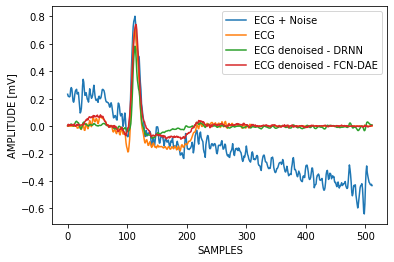

9702


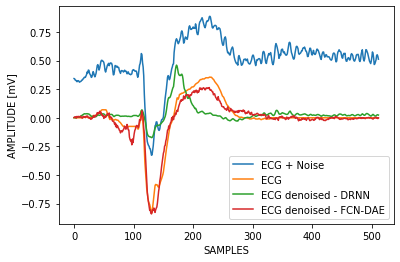

5703


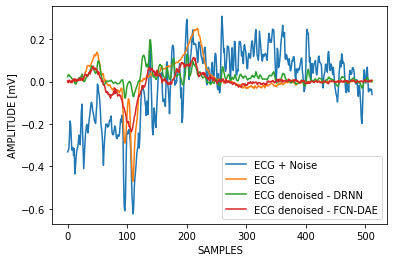

5516


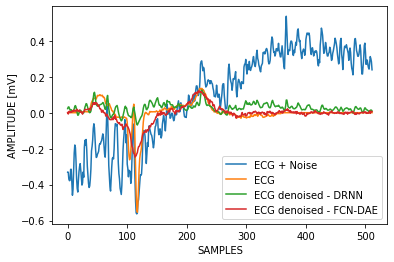

7256


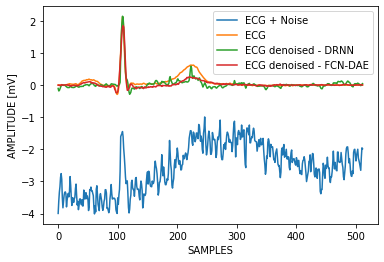

2403


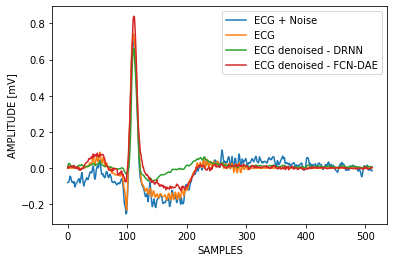

8362


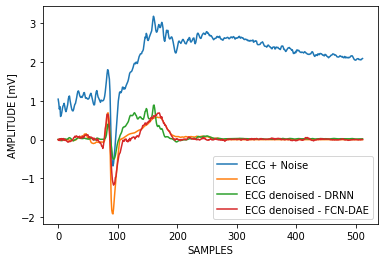

11349


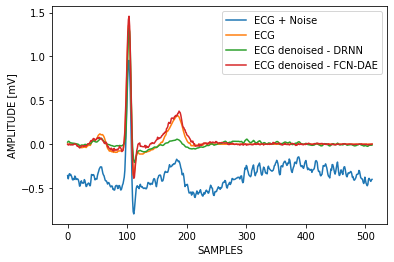

11253


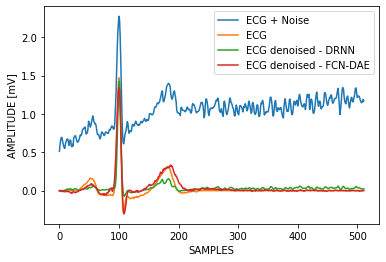

11573


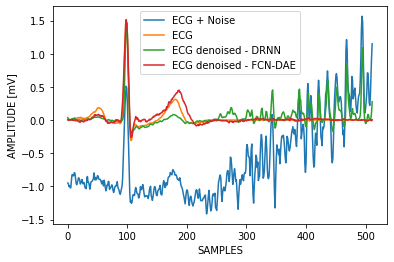

5131


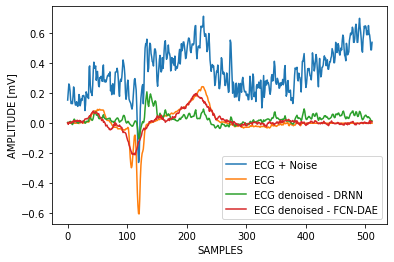

3375


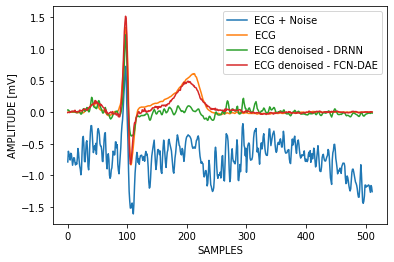

12418


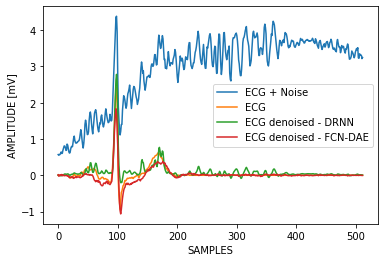

3378


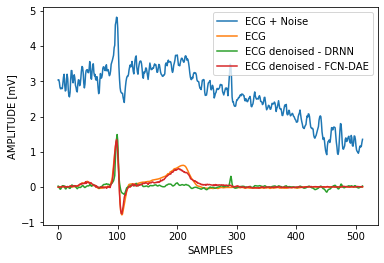

5503


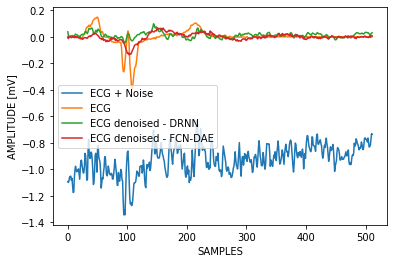

614


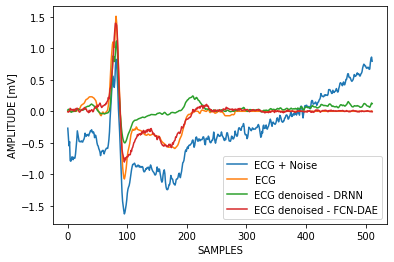

879


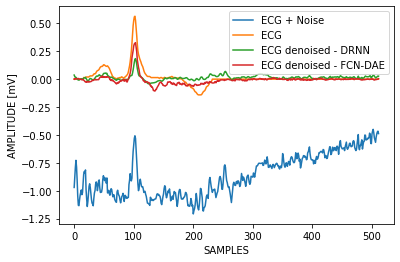

8702


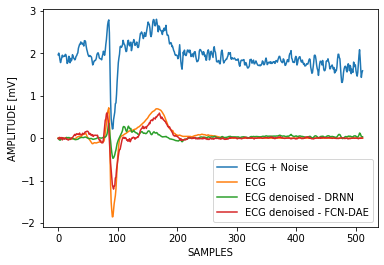

11705


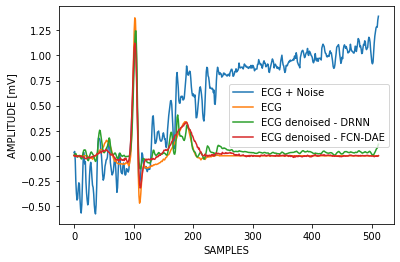

4750


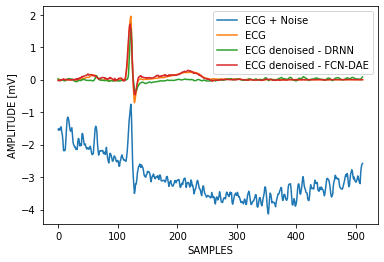

9995


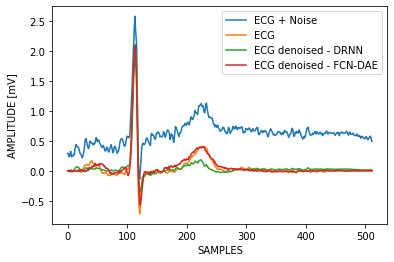

3897


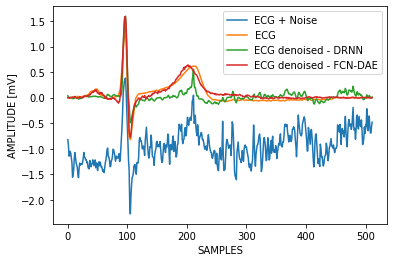

5552


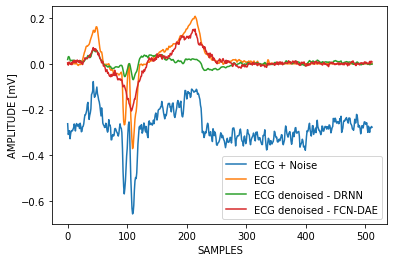

3079


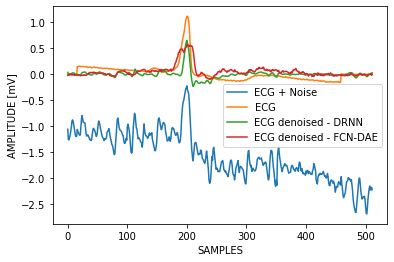

8265


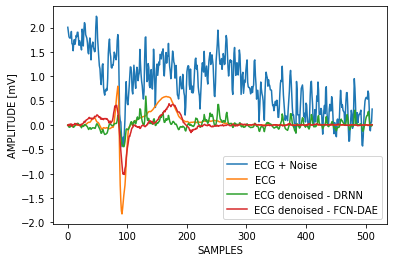

4520


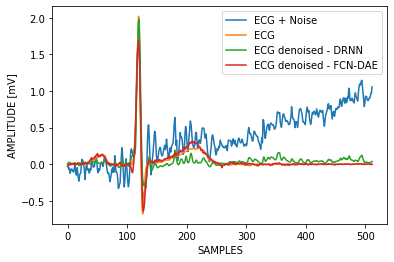

8366


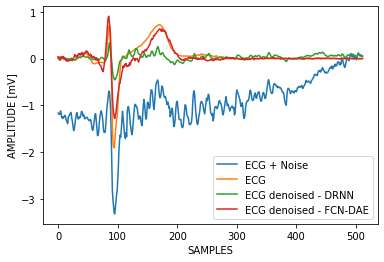

4194


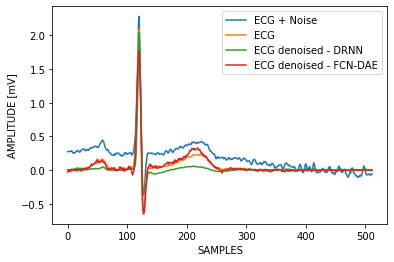

2408


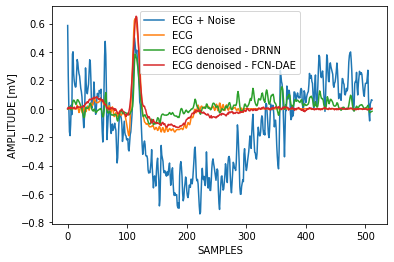

12646


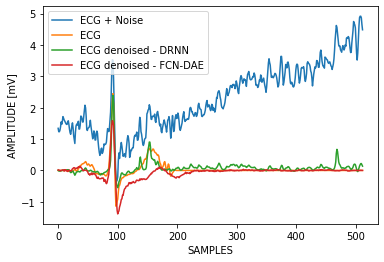

10274


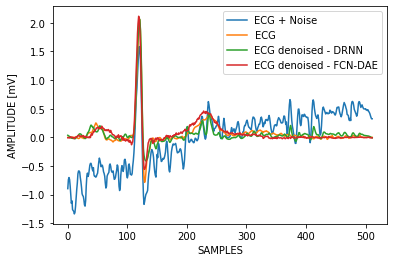

5831


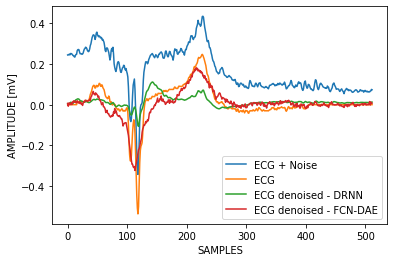

3895


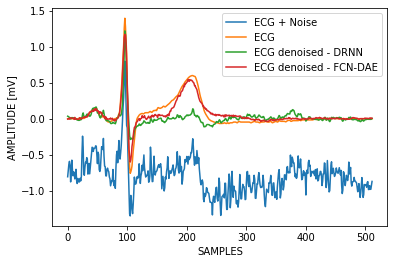

4817


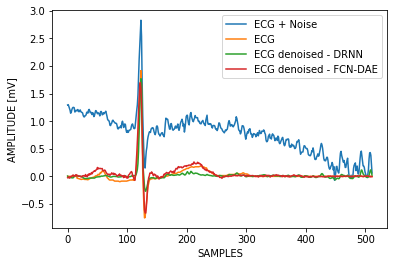

5237


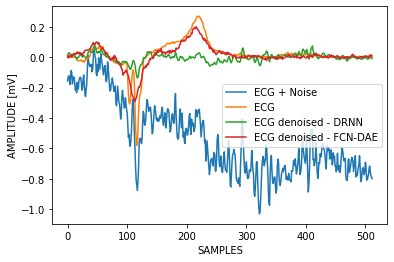

4670


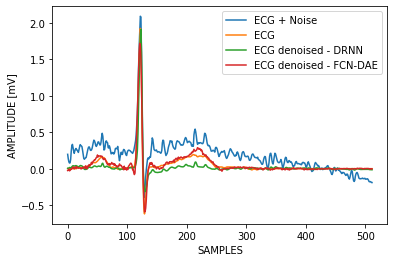

2575


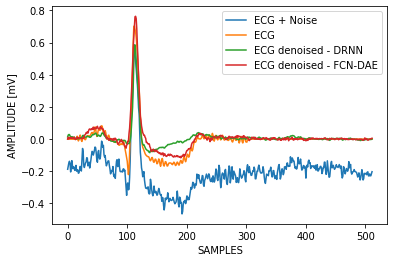

648


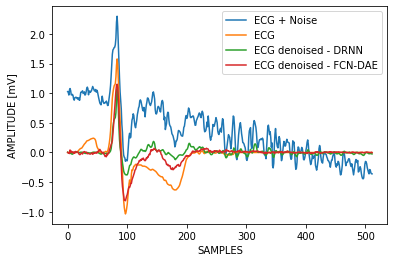

6033


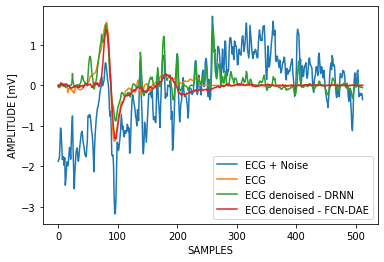

6457


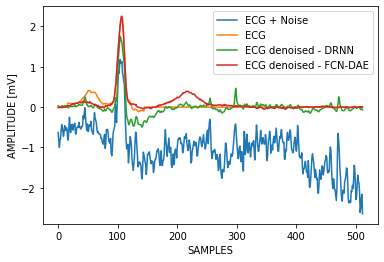

9930


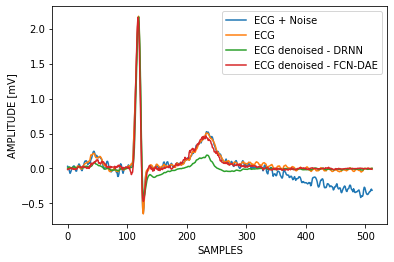

11737


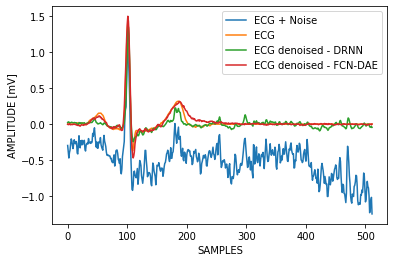

7304


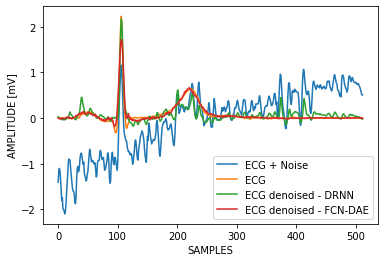

6830


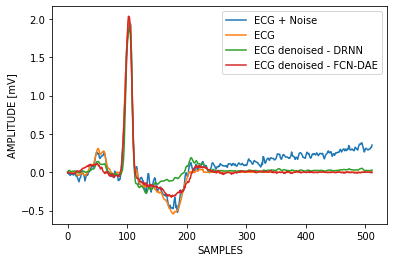

7622


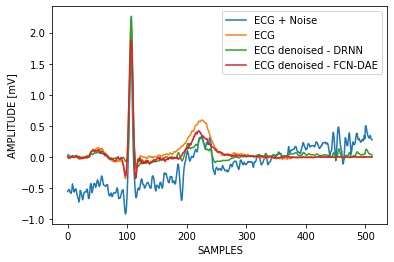

11783


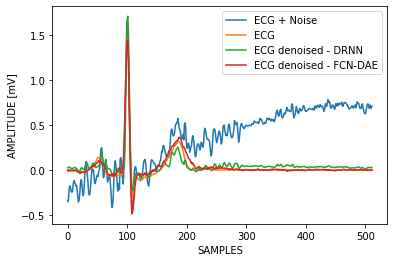

In [12]:
for x in np.random.randint(13000, size=50):
  print(x)
  plt.plot(X_test_1[x], label="ECG + Noise")
  plt.plot(y_test_1[x], label="ECG")
  plt.plot(y_pred_1[x], label="ECG denoised - DRNN")
  plt.plot(y_pred_2[x], label="ECG denoised - FCN-DAE")
  plt.xlabel("SAMPLES")
  plt.ylabel("AMPLITUDE [mV]")
  plt.legend()
  plt.show()